# Multi-Stage Job Advertisement Analysis — Training BERT Zone Identification Model

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mansamoussa/llm-skill-extractor/blob/main/notebooks/02_train_bert.ipynb)

---

### Objective

Train a **multilingual BERT token classification model** that predicts zone labels for each token in a job advertisement, using the preprocessed datasets generated in *01_data_preparation.ipynb*.

This notebook will:

1. Load:
   - The preprocessed `train_dataset` and `test_dataset`
   - The `id2label.json` and `label2id.json` mappings  
2. Initialize a `bert-base-multilingual-cased` model for token classification  
3. Configure and run the full training loop:
   - Optimizer (AdamW)
   - Learning rate scheduler  
   - Weighted loss function to handle class imbalance  
   - Periodic validation with early stopping  
4. Save:
   - The best-performing model checkpoint (`best_model.pt`)
5. Visualize training dynamics:
   - Training loss curve  
   - Validation loss curve  

The resulting model will be used in **03_evaluation.ipynb** for detailed evaluation and in **04_skill_extraction_llm.ipynb** for extracting skills from job advertisements.

### Input Data

- `data/train_dataset.pt` — tokenized, labeled training chunks  
- `data/test_dataset.pt` — tokenized, labeled evaluation chunks  
- `model/id2label.json` — mapping from label IDs → label names  
- `model/label2id.json` — mapping from label names → label IDs  

### Output

- **`model/best_model.pt`** — best model checkpoint based on validation loss  
- **Training and validation loss plots** (visualized in this notebook)

---

# 1. Environment Setup

**Objective**
Install the required Python libraries and prepare the Google Colab environment so that it can run the BERT training pipeline.

**Why I need this**

Google Colab starts with a completely empty Python environment.  
It does not include the libraries required for BERT training, such as:

- `transformers`
- `torch`
- `tensorboard`

Without these, the model cannot be loaded, trained, or evaluated.

**What I did**

- Installed the core libraries (`transformers`, `tensorboard`) quietly using `pip`.
- Imported all required Python modules for:
  - BERT token classification
  - Training loops
  - Loss functions
  - Scheduling
  - Logging
  - Class balancing
- Ensured the notebook environment is fully ready before loading data and training.


In [1]:
!pip install -q transformers tensorboard

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader

from transformers import (
    BertForTokenClassification,
    BertTokenizerFast,
    get_linear_schedule_with_warmup
)

import json
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

from torch.utils.tensorboard import SummaryWriter

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 2. Data Loading and Validation

**Objective**  
Mount Google Drive, define the project directory, and verify that all required preprocessed files from *01_data_preparation.ipynb* are available before starting model training.

**Why I need this**  
Google Colab does not have direct access to project folders or data files stored on my local machine.  
If I do not mount Google Drive and locate the exported datasets from Notebook 01, the training notebook will fail with file-not-found errors when trying to load:
- the tokenized datasets (`train_dataset.pt`, `test_dataset.pt`)
- the label mappings (`id2label.json`, `label2id.json`)

Ensuring these files exist before training prevents long training runs from crashing due to missing inputs.

**What I did**  
- Mounted Google Drive using `drive.mount()` to access the project folder.  
- Defined `PROJECT_ROOT` and constructed the paths to all required input files.  
- Implemented a file-existence check to confirm that all necessary data produced in Notebook 01 is present.  
- Displayed a clear success message if everything is available, or raised a helpful error if files are missing.


In [4]:
import os

PROJECT_ROOT = "/content/drive/MyDrive/GroupWork_GEN03"

# Define paths
train_dataset_path = f"{PROJECT_ROOT}/processed_data/train_dataset.pt"
test_dataset_path  = f"{PROJECT_ROOT}/processed_data/test_dataset.pt"
id2label_path      = f"{PROJECT_ROOT}/model/id2label.json"
label2id_path      = f"{PROJECT_ROOT}/model/label2id.json"

paths = {
    "train_dataset.pt": train_dataset_path,
    "test_dataset.pt": test_dataset_path,
    "id2label.json": id2label_path,
    "label2id.json": label2id_path,
}

# Validate all paths
missing = [name for name, p in paths.items() if not os.path.exists(p)]

if missing:
    raise FileNotFoundError(
        "❌ Missing required input files:\n" +
        "\n".join(f" - {name}" for name in missing) +
        "\n\nPlease verify where Notebook 01 has exported."
    )
else:
    print("✅ All required files found.")

✅ All required files found.


In [5]:
# --- For PyTorch 2.6 unpickling TensorDataset ---
from torch.utils.data import TensorDataset
import torch
torch.serialization.add_safe_globals([TensorDataset])
# -----------------------------------------------------

# Load datasets (weights_only=False for full objects)
train_dataset = torch.load(train_dataset_path, weights_only=False)
test_dataset  = torch.load(test_dataset_path,  weights_only=False)

# Load id2label mapping (keys are strings, convert to int)
with open(id2label_path, "r") as f:
    id2label_raw = json.load(f)

# Convert: {"0": "O"} to {0: "O"}
id2label = {int(k): v for k, v in id2label_raw.items()}

# Create label2id: {"O": 0, ...}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(label2id)

id2label, label2id, num_labels

({0: 'O',
  1: 'Fähigkeiten und Inhalte',
  2: 'Abschlüsse',
  3: 'Anstellung',
  4: 'Erfahrung',
  5: 'Challenges',
  6: 'Bewerbungsprozess',
  7: 'Firmenbeschreibung',
  8: 'Benefits',
  9: 'Arbeitsumfeld',
  10: 'Firmenkundenbeschreibung'},
 {'O': 0,
  'Fähigkeiten und Inhalte': 1,
  'Abschlüsse': 2,
  'Anstellung': 3,
  'Erfahrung': 4,
  'Challenges': 5,
  'Bewerbungsprozess': 6,
  'Firmenbeschreibung': 7,
  'Benefits': 8,
  'Arbeitsumfeld': 9,
  'Firmenkundenbeschreibung': 10},
 11)

In [6]:
%%capture
tokenizer = BertTokenizerFast.from_pretrained("bert-base-multilingual-cased")
model = BertForTokenClassification.from_pretrained(
    "bert-base-multilingual-cased",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
device

'cuda'

In [13]:
batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

len(train_loader), len(test_loader)

(374, 94)

In [14]:
# Sanity check: take one batch and run it through the model
batch = next(iter(train_loader))
input_ids, labels, attention_mask = [b.to(device) for b in batch]

print("input_ids:", input_ids.shape)
print("attention_mask:", attention_mask.shape)
print("labels:", labels.shape)

with torch.no_grad():
    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask,
        labels=labels
    )

print("Forward pass OK — loss:", outputs.loss.item())


input_ids: torch.Size([8, 510])
attention_mask: torch.Size([8, 510])
labels: torch.Size([8, 510])
Forward pass OK — loss: 0.6803174614906311


In [15]:
all_labels = []
for _, labels, _ in train_loader:
    all_labels.extend(labels.view(-1).numpy())

all_labels = np.array(all_labels)
valid_mask = all_labels != label2id["O"]
filtered_labels = all_labels[valid_mask]

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array(list(label2id.values())),
    y=all_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
class_weights

tensor([ 0.2424,  0.3548,  3.0426,  1.3484,  3.8196, 65.3415,  0.8648,  1.3924,
         1.4231, 78.5949,  8.4421], device='cuda:0')

In [16]:
epochs = 15
learning_rate = 3e-5

optimizer = AdamW(model.parameters(), lr=learning_rate)

num_training_steps = len(train_loader) * epochs
num_warmup_steps = int(0.1 * num_training_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
)

loss_fn = nn.CrossEntropyLoss(weight=class_weights, ignore_index=label2id["O"])

writer = SummaryWriter(log_dir="../logs/train")

In [17]:
from tqdm import tqdm

# Where to save the best checkpoint
model_save_path = f"{PROJECT_ROOT}/model/best_model.pt"

best_val_loss = float("inf")
patience = 4
counter = 0

# Lists for plotting later
train_losses = []
val_losses = []

for epoch in range(epochs):
    print(f"\n===== Epoch {epoch+1}/{epochs} =====")

    # ------------------------ TRAINING ------------------------
    model.train()
    total_loss = 0
    train_pbar = tqdm(train_loader, desc="Training", leave=False)

    for batch in train_pbar:
        input_ids, labels, attention_mask = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        train_pbar.set_postfix({"loss": f"{loss.item():.4f}"})

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    writer.add_scalar("Loss/train", avg_train_loss, epoch)
    print(f"Training Loss: {avg_train_loss:.4f}")

    # ------------------------ VALIDATION ------------------------
    model.eval()
    val_loss = 0
    val_pbar = tqdm(test_loader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in val_pbar:
            input_ids, labels, attention_mask = [b.to(device) for b in batch]
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            val_loss += loss.item()
            val_pbar.set_postfix({"val_loss": f"{loss.item():.4f}"})

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    writer.add_scalar("Loss/val", avg_val_loss, epoch)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # ------------------------ CHECKPOINT + EARLY STOPPING ------------------------
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), model_save_path)
        print("✓ Saved new best model")
        counter = 0
    else:
        counter += 1
        print(f"No improvement. Patience counter: {counter}/{patience}")

        if counter >= patience:
            print("⛔ Early stopping triggered — no improvement.")
            break

writer.close()

model.num_parameters()



===== Epoch 1/15 =====


Training Loss: 0.4394


Validation Loss: 0.4279
✓ Saved new best model

===== Epoch 2/15 =====


Training Loss: 0.3802


Validation Loss: 0.3751
✓ Saved new best model

===== Epoch 3/15 =====


Training Loss: 0.2832


Validation Loss: 0.3520
✓ Saved new best model

===== Epoch 4/15 =====


Training Loss: 0.2218


Validation Loss: 0.3508
✓ Saved new best model

===== Epoch 5/15 =====


Training Loss: 0.1656


Validation Loss: 0.3709
No improvement. Patience counter: 1/4

===== Epoch 6/15 =====


Training Loss: 0.1280


Validation Loss: 0.3960
No improvement. Patience counter: 2/4

===== Epoch 7/15 =====


Training Loss: 0.1025


Validation Loss: 0.3838
No improvement. Patience counter: 3/4

===== Epoch 8/15 =====


Training Loss: 0.0847


Validation Loss: 0.3948
No improvement. Patience counter: 4/4
⛔ Early stopping triggered — no improvement.


177271307

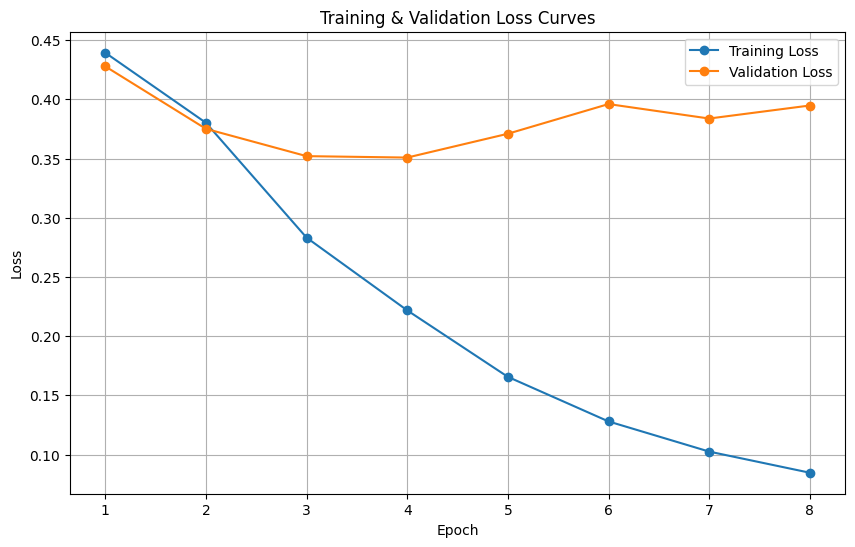

In [18]:
import matplotlib.pyplot as plt

# Training and validation losses collected from TensorBoard logs stored during training

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, train_losses, label='Training Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Curves')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from collections import Counter

all_train_labels = []
for _, labels, _ in train_dataset:
    all_train_labels += labels.tolist()

label_counts = Counter([id2label[l] for l in all_train_labels])

label_counts


Counter({'Fähigkeiten und Inhalte': 390964,
         'Benefits': 97479,
         'Erfahrung': 36318,
         'Bewerbungsprozess': 160400,
         'Firmenbeschreibung': 99623,
         'O': 572349,
         'Anstellung': 102874,
         'Firmenkundenbeschreibung': 16432,
         'Abschlüsse': 45593,
         'Challenges': 2123,
         'Arbeitsumfeld': 1765})

In [20]:
total = 0
wrong = 0

for batch in test_loader:
    input_ids, labels, attention_mask = [b.to(device) for b in batch]
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs.logits, dim=-1)

    mask = labels != label2id["O"]
    total += mask.sum().item()
    wrong += (preds[mask] != labels[mask]).sum().item()

print(f"Token Accuracy (excluding O tokens): {1 - wrong/total:.3f}")

Token Accuracy (excluding O tokens): 0.879
